In [12]:
import cv2
import numpy as np

# Example contour (you would get this from cv2.findContours)
# contour = ...
# rect = cv2.minAreaRect(contour)

# Example rectangle from minAreaRect (center, size, rotation)
rect = ((100, 80), (60, 30), 0)  # Example values
box = cv2.boxPoints(rect)         # Get the 4 corners in pixels
box = np.array(box, dtype=np.float32)

# Calibration values (mm per pixel in each axis)
mm_per_px_x = 0.05  # e.g., 1 pixel in X direction = 0.05 mm
mm_per_px_y = 0.06  # e.g., 1 pixel in Y direction = 0.06 mm

def scaled_distance(p1, p2):
    """
    Compute the real-world distance between two points when X and Y
    have different mm-per-pixel scaling.
    """
    dx_mm = (p2[0] - p1[0]) * mm_per_px_x
    dy_mm = (p2[1] - p1[1]) * mm_per_px_y
    return np.sqrt(dx_mm**2 + dy_mm**2)

# Calculate lengths of two adjacent sides
side1_mm = scaled_distance(box[0], box[1])
side2_mm = scaled_distance(box[1], box[2])

print(f"Side 1 length: {side1_mm:.2f} mm")
print(f"Side 2 length: {side2_mm:.2f} mm")


Side 1 length: 1.80 mm
Side 2 length: 3.00 mm


mm/px X: 0.0414, mm/px Y: 0.0412


(np.float64(-0.5), np.float64(4283.5), np.float64(5711.5), np.float64(-0.5))

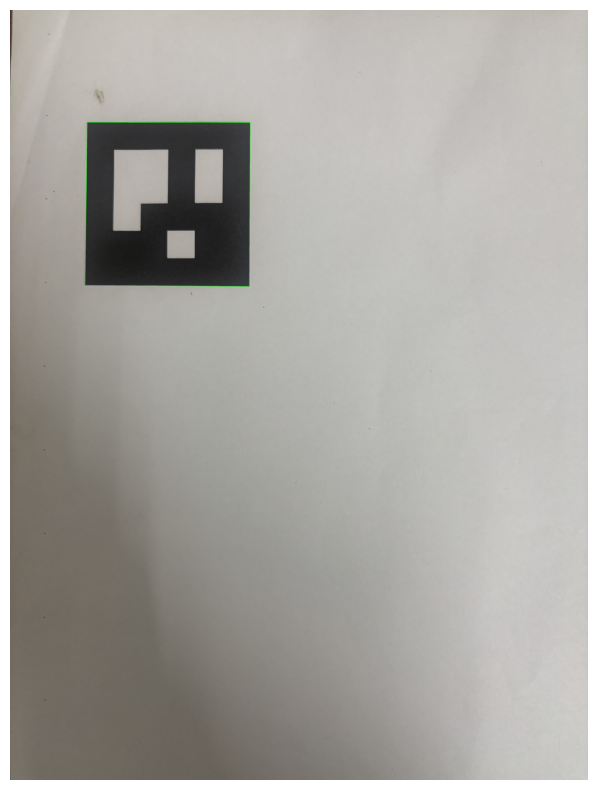

In [17]:
# Calculate mm per pixels using aruco markers

import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_mm_per_px(image, marker_length_mm, marker_height_mm, aruco_dict=cv2.aruco.DICT_4X4_50):
    """
    Calculate mm per pixel in both X and Y directions using an ArUco marker.

    Args:
        image: Input image containing the marker.
        marker_length_mm: Real-world marker width in mm.
        marker_height_mm: Real-world marker height in mm.
        aruco_dict: ArUco dictionary type.

    Returns:
        mm_per_px_x, mm_per_px_y, image_with_marker
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    dictionary = cv2.aruco.getPredefinedDictionary(aruco_dict)
    parameters = cv2.aruco.DetectorParameters()

    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    corners, ids, _ = detector.detectMarkers(gray)

    if ids is None or len(corners) == 0:
        print("No ArUco marker detected!")
        return None, None, image

    # Use the first detected marker
    c = corners[0][0]  # shape: (4, 2)

    # Draw detected marker
    image_with_marker = image.copy()
    cv2.polylines(image_with_marker, [c.astype(int)], True, (0, 255, 0), 2)

    # Pixel dimensions
    pixel_width = np.linalg.norm(c[0] - c[1])
    pixel_height = np.linalg.norm(c[1] - c[2])

    # Convert to mm/px
    mm_per_px_x = marker_length_mm / pixel_width
    mm_per_px_y = marker_height_mm / pixel_height

    return mm_per_px_x, mm_per_px_y, image_with_marker


# Example usage
image = cv2.imread(r"c:\Users\melroy.pereira1\OneDrive - Autoliv\Documents\lab_images\IMG_3846.jpeg")
mm_x, mm_y, debug_img = calculate_mm_per_px(image, marker_length_mm=50, marker_height_mm=50)
print(f"mm/px X: {mm_x:.4f}, mm/px Y: {mm_y:.4f}")

plt.figure(figsize=[10,10])
plt.imshow(debug_img[:,:,::-1]);plt.axis("off")

# cv2.imshow("Detected Marker", debug_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread(r"c:\Users\melroy.pereira1\OneDrive - Autoliv\Documents\lab_images\IMG_3846.jpeg")

# Detect ArUco
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

parameters = cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

corners, ids, rejected = detector.detectMarkers(img)
print(f"Detected {len(corners)} markers.")

if ids is not None:
    for i in range(len(ids)):
        pts = corners[i][0]  # shape: (4, 2) - 4 corner points
        print("Corners:", pts)

        # Calculate pixel width and height from the detected corners
        width_px = np.linalg.norm(pts[0] - pts[1])
        height_px = np.linalg.norm(pts[1] - pts[2])

        print(f"Width in pixels: {width_px:.2f}")
        print(f"Height in pixels: {height_px:.2f}")


Detected 1 markers.
572.0000, 833.0000
1780.0000, 835.0000
1774.0000, 2050.0000
556.0000, 2042.0000
Corners: [[ 572.  833.]
 [1780.  835.]
 [1774. 2050.]
 [ 556. 2042.]]
Width in pixels: 1208.00
Height in pixels: 1215.01


In [6]:
pts[0] - pts[1]
pts[1] - pts[2]

array([    6., -1215.], dtype=float32)

In [ ]:
W_mm = 50  # Real-world width in mm
H_mm = 50  # Real-world height in mm

mm_per_pixel_x = W_mm / width_px
mm_per_pixel_y = H_mm / height_px

print(f"mm per pixel (X direction): {mm_per_pixel_x:.4f}")
print(f"mm per pixel (Y direction): {mm_per_pixel_y:.4f}")


In [ ]:
"""
aruco_mm_per_pixel.py

Purpose:
- Detect a printed ArUco marker in an image
- Optionally undistort using camera calibration
- Perform subpixel refinement on detected corners
- Compute a perspective transform that maps the detected marker to a perfect square of known real-world size
- Warp the marker region to a higher-resolution image to reduce quantization error
- Provide mm-per-pixel conversion and interactive measurement (click two points)

Usage:
python aruco_mm_per_pixel.py --image captured.jpg --marker_mm 50 --scale 10 --marker_id 23 --calib calib.yaml

Arguments:
- --image : path to input image (required)
- --marker_mm : printed marker side length in millimeters (square marker). Default 50
- --marker_id : ArUco id used (default 23)
- --dict : ArUco dictionary (choices: DICT_4X4_50 etc.). Default DICT_4X4_50
- --scale : pixels per millimeter in the warped marker output (default 10 px/mm). Higher -> more accurate subpixel handling
- --calib : optional YAML file containing camera matrix and distCoeffs (keys: camera_matrix, dist_coeff)
- --show : show GUI windows for interactive clicks
- --out_warp : save warped marker image path

Notes on accuracy:
- We enable subpixel corner refinement and recommend using a camera calibration file to remove lens distortion if you need sub-mm accuracy.
- Keep the camera fixed between calibration and measurement. Print marker flat and avoid warping of paper.

"""

import cv2
import numpy as np
import argparse
import yaml
import sys


def load_calib(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    # expect keys camera_matrix and dist_coeff, both lists
    K = np.array(data.get('camera_matrix'))
    dist = np.array(data.get('dist_coeff'))
    return K, dist


def detect_aruco_corners(img, aruco_dict, parameters, refine_subpix=True):
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejected = detector.detectMarkers(img)
    if ids is None or len(ids) == 0:
        return None, None

    # pick first marker (or you can search for specific id)
    # corners is list of shape (N,1,4,2) -> take corners[0][0]
    corners = corners[0].reshape((4,2)).astype(np.float32)

    if refine_subpix:
        # refine corners with cornerSubPix on grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        win = (5,5)
        zero = (-1,-1)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.001)
        # cornerSubPix expects initial points as Nx1x2
        pts = corners.reshape(-1,1,2)
        cv2.cornerSubPix(gray, pts, win, zero, criteria)
        corners = pts.reshape((4,2))

    return corners, ids[0][0]


def order_corners(corners):
    # Ensure corners are in consistent order: top-left, top-right, bottom-right, bottom-left
    # Here corners is (4,2)
    rect = np.zeros((4,2), dtype=np.float32)
    s = corners.sum(axis=1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]
    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]
    return rect


def compute_warp_and_mm_per_px(img, corners_px, marker_mm, scale_ppmm=10, dst_margin_mm=0):
    """
    corners_px: (4,2) ordered corners
    marker_mm: side length in mm
    scale_ppmm: desired pixels per mm in the warped image (increase for more accuracy)
    dst_margin_mm: optional margin around marker in mm
    Returns: warped_image, H (perspective homography from src->dst), mm_per_pixel
    """
    # Destination rectangle size in pixels
    out_w = int(round((marker_mm + 2*dst_margin_mm) * scale_ppmm))
    out_h = out_w

    dst = np.array([
        [dst_margin_mm * scale_ppmm, dst_margin_mm * scale_ppmm],
        [(dst_margin_mm + marker_mm) * scale_ppmm, dst_margin_mm * scale_ppmm],
        [(dst_margin_mm + marker_mm) * scale_ppmm, (dst_margin_mm + marker_mm) * scale_ppmm],
        [dst_margin_mm * scale_ppmm, (dst_margin_mm + marker_mm) * scale_ppmm]
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(corners_px, dst)
    warped = cv2.warpPerspective(img, M, (out_w, out_h), flags=cv2.INTER_LINEAR)

    mm_per_px = 1.0 / scale_ppmm
    return warped, M, mm_per_px


def interactive_measurement(img, H, mm_per_px):
    print("\nInteractive mode: click two points in the ORIGINAL image window to measure distance.")
    pts = []
    win_name = 'orig_click'
    clone = img.copy()

    def on_mouse(event, x, y, flags, param):
        nonlocal pts, clone
        if event == cv2.EVENT_LBUTTONDOWN:
            pts.append((x,y))
            cv2.circle(clone, (x,y), 4, (0,255,0), -1)
            cv2.imshow(win_name, clone)

    cv2.namedWindow(win_name)
    cv2.setMouseCallback(win_name, on_mouse)
    cv2.imshow(win_name, clone)
    print("Click two points (left-click). Press 'q' to quit interactive mode.")

    while True:
        key = cv2.waitKey(0) & 0xFF
        if key == ord('q'):
            break
        if len(pts) >= 2:
            p1 = np.array([[pts[0]]], dtype=np.float32)  # 1x1x2
            p2 = np.array([[pts[1]]], dtype=np.float32)
            # Transform to marker coordinate system (warped coords in pixels)
            H_inv = np.linalg.inv(H)
            tp1 = cv2.perspectiveTransform(p1, H_inv)[0,0]  # in destination pixels
            tp2 = cv2.perspectiveTransform(p2, H_inv)[0,0]
            # distance in pixels in warped image -> convert to mm via mm_per_px
            px_dist = np.linalg.norm(tp1 - tp2)
            mm_dist = px_dist * mm_per_px
            print(f"Pixel distance (warped coords): {px_dist:.3f} px -> {mm_dist:.3f} mm")
            pts = []
            # reset clone
            clone = img.copy()
            cv2.imshow(win_name, clone)
    cv2.destroyWindow(win_name)


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--image', required=True)
    parser.add_argument('--marker_mm', type=float, default=50.0, help='Physical printed marker side length in mm')
    parser.add_argument('--marker_id', type=int, default=23)
    parser.add_argument('--dict', type=str, default='DICT_4X4_50')
    parser.add_argument('--scale', type=float, default=10.0, help='pixels per mm in warped output (ppmm)')
    parser.add_argument('--calib', type=str, default=None, help='optional camera calibration yaml')
    parser.add_argument('--show', action='store_true')
    parser.add_argument('--out_warp', type=str, default='warped_marker.png')
    args = parser.parse_args()

    img = cv2.imread(args.image)
    if img is None:
        print('Failed to read image:', args.image)
        sys.exit(1)

    # optional undistort
    if args.calib:
        try:
            K, dist = load_calib(args.calib)
            h,w = img.shape[:2]
            newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 0)
            img = cv2.undistort(img, K, dist, None, newcameramtx)
            print('Undistorted using calibration file.')
        except Exception as e:
            print('Failed to load calib file:', e)

    # prepare aruco
    aruco_dict = getattr(cv2.aruco, args.dict)
    ar_dict = cv2.aruco.Dictionary_get(aruco_dict)
    params = cv2.aruco.DetectorParameters()
    params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

    corners, detected_id = detect_aruco_corners(img, ar_dict, params, refine_subpix=True)
    if corners is None:
        print('No markers found')
        sys.exit(1)

    print(f'Detected marker id: {detected_id}\nCorners (px):')
    for c in corners:
        print(f'  {c[0]:.3f}, {c[1]:.3f}')

    ordered = order_corners(corners)
    # compute raw width and height in pixels (diagonals between consecutive corners)
    width_px = np.linalg.norm(ordered[0] - ordered[1])
    height_px = np.linalg.norm(ordered[1] - ordered[2])
    print(f'Raw width_px: {width_px:.3f}, height_px: {height_px:.3f}')

    warped, H, mm_per_px = compute_warp_and_mm_per_px(img, ordered, args.marker_mm, scale_ppmm=args.scale)

    print(f'Warped image saved to: {args.out_warp}')
    cv2.imwrite(args.out_warp, warped)
    print(f'Implied mm per pixel (after warp): {mm_per_px:.6f} mm/px (i.e. {1.0/mm_per_px:.2f} px/mm)')

    # Optionally show windows and interactive measure
    if args.show:
        cv2.imshow('warped_marker', warped)
        cv2.imshow('original', img)
        print('\nPress any key on a window to continue to interactive measurement...')
        cv2.waitKey(0)
        interactive_measurement(img, H, mm_per_px)
        cv2.destroyAllWindows()

    print('\nDone.')

if __name__ == '__main__':
    main()


In [10]:
import cv2
import numpy as np

# ==== Step 1: Load captured image ====
img = cv2.imread(r"c:\Users\melroy.pereira1\OneDrive - Autoliv\Documents\lab_images\IMG_3846.jpeg")

# ==== Step 2: Detect ArUco ====
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
parameters = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

corners, ids, _ = detector.detectMarkers(img)

if ids is not None:
    # We'll assume only one marker detected
    pts_src = corners[0][0]  # shape: (4, 2)
    print("Detected corners (pixels):", pts_src)

    # ==== Step 3: Define real-world size (mm) ====
    W_mm = 50.0  # width in mm of printed marker
    H_mm = 50.0  # height in mm

    # ==== Step 4: Perspective transform ====
    # Destination points: a perfect rectangle in pixel space
    # Here we choose output size in pixels for warping
    output_width_px = 1000
    output_height_px = 1000

    pts_dst = np.array([
        [0, 0],
        [output_width_px - 1, 0],
        [output_width_px - 1, output_height_px - 1],
        [0, output_height_px - 1]
    ], dtype=np.float32)

    # Compute transformation matrix
    M = cv2.getPerspectiveTransform(np.array(pts_src, dtype=np.float32), pts_dst)

    # Warp image so marker is perfectly aligned
    warped = cv2.warpPerspective(img, M, (output_width_px, output_height_px))

    # ==== Step 5: Calculate mm per pixel ====
    mm_per_pixel_x = W_mm / output_width_px
    mm_per_pixel_y = H_mm / output_height_px
    print(f"mm/px X: {mm_per_pixel_x:.6f}, mm/px Y: {mm_per_pixel_y:.6f}")

    # ==== Step 6: Save and display result ====
    cv2.imshow("Warped Marker", warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

else:
    print("No ArUco markers detected.")


Detected corners (pixels): [[ 572.  833.]
 [1780.  835.]
 [1774. 2050.]
 [ 556. 2042.]]
mm/px X: 0.050000, mm/px Y: 0.050000


In [3]:
import cv2
import numpy as np

# ==== Step 1: Load captured image ====
img = cv2.imread(r"c:\Users\melroy.pereira1\OneDrive - Autoliv\Documents\lab_images\exp_2\IMG_3850.jpeg")

# ==== Step 2: Detect ArUco ====
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
parameters = cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX  # better accuracy
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

corners, ids, _ = detector.detectMarkers(img)

if ids is not None:
    # We'll assume only one marker detected
    pts_src = corners[0][0]  # shape: (4, 2)
    print("Detected corners (pixels):", pts_src)

    # ==== Step 3: Define real-world size (mm) ====
    W_mm = 51.2  # width in mm of printed marker
    H_mm = 51.2  # height in mm

    # ==== Step 4: Compute original pixel width/height ====
    width_px = int(np.linalg.norm(pts_src[0] - pts_src[1]))
    height_px = int(np.linalg.norm(pts_src[1] - pts_src[2]))

    print(f"Original detected size: {width_px}px × {height_px}px")

    # ==== Step 5: Perspective transform ====
    pts_dst = np.array([
        [0, 0],
        [width_px - 1, 0],
        [width_px - 1, height_px - 1],
        [0, height_px - 1]
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(np.array(pts_src, dtype=np.float32), pts_dst)

    warped = cv2.warpPerspective(img, M, (width_px, height_px))

    # ==== Step 6: Calculate mm per pixel ====
    mm_per_pixel_x = W_mm / width_px
    mm_per_pixel_y = H_mm / height_px
    print(f"mm/px X: {mm_per_pixel_x:.6f}, mm/px Y: {mm_per_pixel_y:.6f}")

    # ==== Step 7: Show results ====
    cv2.imshow("Warped Marker", warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

else:
    print("No ArUco markers detected.")


Detected corners (pixels): [[2431.9048 2466.7249]
 [3496.8271 2452.732 ]
 [3506.0999 3520.1733]
 [2443.5579 3535.3838]]
Original detected size: 1065px × 1067px
mm/px X: 0.048075, mm/px Y: 0.047985
